In [309]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn

In [310]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [311]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

In [312]:
feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
print(feeds_df.shape)
feeds_df.head()

(2555, 13)


,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]
1,5eabae544bc32c003663b786,False,5eabad0e9890ea0050e7c800,2020-05-01 05:06:28.767,True,False,0.235294,"Hi guys, I am a chemical Engineer. But my pass...",POST,2020-05-01 09:33:16.347,[],[],[]
2,5eaa94e911914b00283bcaf5,False,5eaa928fd9e8980022200613,2020-04-30 09:05:45.211,True,False,0.888889,@ShitalKakad Which Indian food to include in t...,QUESTION,2020-05-13 02:38:07.669,[],[],[]
3,5eaad78e11914b00283bcb25,False,5ea974f75e00240036a11833,2020-04-30 13:50:06.761,True,False,1.647059,Hello everyone. Looking forward to connect wit...,POST,2020-05-01 08:14:41.114,[],[],[]
4,5eac79d6bfe8020026a3bc63,False,5eac5a685ed505002290ca9b,2020-05-01 19:34:46.428,True,False,0.937500,Hey me Ankita ..I want to get work from home j...,POST,2020-05-17 20:33:23.220,[],[],[]


# Interactions Data

In [313]:
likes_df = pd.read_csv(os.getcwd() + '/Datasets/likes_coll_df.csv')
likes_df['createdAt'] = pd.to_datetime(likes_df['createdAt'])
likes_df['updatedAt'] = pd.to_datetime(likes_df['updatedAt'])
likes_df = likes_df[likes_df['type'] != 'ARTICLE']
print(likes_df.shape)
likes_df.head(1)

(6866, 9)


,likeId,commentId,createdAt,emojiType,isActive,referenceId,type,updatedAt,userId
0,5df502726c5e063edec6360b,5df4b061a68eb700165a664a,2019-12-14 15:40:34.645,Like,True,NaN,COMMENT,2019-12-14 15:40:34.645,5df45b5b7e4ea600161b8ede


In [314]:
comments_df = pd.read_csv(os.getcwd() + '/Datasets/comments_df.csv')
comments_df['createdAt'] = pd.to_datetime(comments_df['createdAt'])
print(comments_df.shape)
comments_df.head(1)

(7241, 8)


,commentId,authorId,createdAt,isActive,isSubComment,referenceId,type,comment_text
0,5df47e0b7e4ea600161b94b3,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,True,False,5df4699b7e4ea600161b913e,QUESTION,Hi Pihu. I strongly believe you should start y...


In [315]:
bookmarks_df = pd.read_csv(os.getcwd() + '/Datasets/bookmarks_coll_df.csv')
bookmarks_df['createdAt'] = pd.to_datetime(bookmarks_df['createdAt'])
bookmarks_df['updatedAt'] = pd.to_datetime(bookmarks_df['updatedAt'])
bookmarks_df = bookmarks_df[bookmarks_df['type'] != 'COMPANY']
print(bookmarks_df.shape)
bookmarks_df.head(1)

(249, 7)


,bookmarkId,createdAt,isActive,referenceFeedId,type,updatedAt,userId
0,5e5e1df0038098664944f081,2020-03-03 09:05:52.348,True,5e5e195568860c00163d49db,POST,2020-03-16 09:37:54.993,5df4c077a68eb700165a66c3


In [316]:
post_likes_df = likes_df[likes_df['type'] != 'COMMENT']
print(post_likes_df.shape)
post_likes_df = post_likes_df[['likeId', 'referenceId', 'userId', 'createdAt', 'type']]
post_likes_df = post_likes_df.rename(columns = {'likeId':'eventId', 'referenceId':'contentId', 'userId':'personId'})
post_likes_df['eventType'] = 'LIKE'

(3749, 9)


In [317]:
likes_df_formatted = post_likes_df
likes_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [318]:
comments_df_formatted = comments_df[['commentId', 'referenceId', 'authorId', 'createdAt', 'type', 'isSubComment']]
comments_df_formatted = comments_df_formatted.rename(columns = {'commentId':'eventId', 'referenceId':'contentId', 'authorId':'personId'})
comments_df_formatted['eventType'] = np.where(comments_df_formatted['isSubComment'] == False, 'COMMENT', 'SUBCOMMENT')
comments_df_formatted = comments_df_formatted.drop(['isSubComment'], axis=1)
comments_df_formatted.head(1)


,eventId,contentId,personId,createdAt,type,eventType
0,5df47e0b7e4ea600161b94b3,5df4699b7e4ea600161b913e,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,QUESTION,COMMENT


In [319]:
bookmarks_df_formatted = bookmarks_df[['bookmarkId', 'referenceFeedId', 'userId', 'createdAt', 'type']]
bookmarks_df_formatted = bookmarks_df_formatted.rename(columns = {'bookmarkId':'eventId', 'referenceFeedId':'contentId', 'userId':'personId'})
bookmarks_df_formatted['eventType'] = 'BOOKMARK'
bookmarks_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
0,5e5e1df0038098664944f081,5e5e195568860c00163d49db,5df4c077a68eb700165a66c3,2020-03-03 09:05:52.348,POST,BOOKMARK


In [320]:
interactions_df = likes_df_formatted.append([comments_df_formatted, bookmarks_df_formatted])
print(interactions_df.shape)
interactions_df.head(1)

(11239, 6)


,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [321]:
interaction_summary = interactions_df.groupby(['personId'])['contentId'].nunique().reset_index()
interaction_summary.columns = ['personId', 'content_ct']
interaction_summary = interaction_summary.sort_values(['content_ct'], ascending=False)
print("Total Users:", interaction_summary.shape)
print("Users with more than 1 content interaction:", interaction_summary[interaction_summary['content_ct']>1].shape)
interaction_summary.head(1)


Total Users: (1799, 2)
Users with more than 1 content interaction: (733, 2)


,personId,content_ct
121,5df74455d092c70016203cc2,258


# Data Wrangling

In [322]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
#   'FOLLOW': 3.0,
   'COMMENT': 4.0,
    'SUBCOMMENT': 4.0
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [323]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1799
# users with 1 interactions: 1066
# users with at least 2 interactions: 733


In [324]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_multi_inter_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_multi_inter_users_df))

# of interactions: 11239
# of interactions from users with at least 2 interactions: 9811


In [325]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 11239
# of interactions from users with 1 interaction: 1428


In [326]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_multi_df = interactions_from_multi_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_multi_df))
interactions_multi_df.head()

# of unique user/item interactions: 7716


,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df729fad092c70016203aae,1.584963
1,5df38de0b2694d0016bdb71f,5dfaf290f1289d0016d35420,1.584963
2,5df38de0b2694d0016bdb71f,5dfb23eef1289d0016d3559a,2.321928
3,5df38de0b2694d0016bdb71f,5dff09678a0466001664edf5,2.321928
4,5df38de0b2694d0016bdb71f,5e07659bfefbd10016d14987,1.584963


In [327]:
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_single_df))
interactions_single_df.head()

# of unique user/item interactions: 1066


,personId,contentId,eventStrength
0,5df454d27e4ea600161b8e2a,5df462557e4ea600161b9005,2.321928
1,5df458847e4ea600161b8e7e,5df462ba7e4ea600161b9016,2.321928
2,5df45a987e4ea600161b8ec4,5e82c672459bed0028b63983,2.321928
3,5df462697e4ea600161b9009,5df469d97e4ea600161b9149,2.321928
4,5df462f87e4ea600161b9028,5df45ae07e4ea600161b8ed9,2.807355


In [328]:
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()

,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df729fad092c70016203aae,1.584963
1,5df38de0b2694d0016bdb71f,5dfaf290f1289d0016d35420,1.584963
2,5df38de0b2694d0016bdb71f,5dfb23eef1289d0016d3559a,2.321928
3,5df38de0b2694d0016bdb71f,5dff09678a0466001664edf5,2.321928
4,5df38de0b2694d0016bdb71f,5e07659bfefbd10016d14987,1.584963


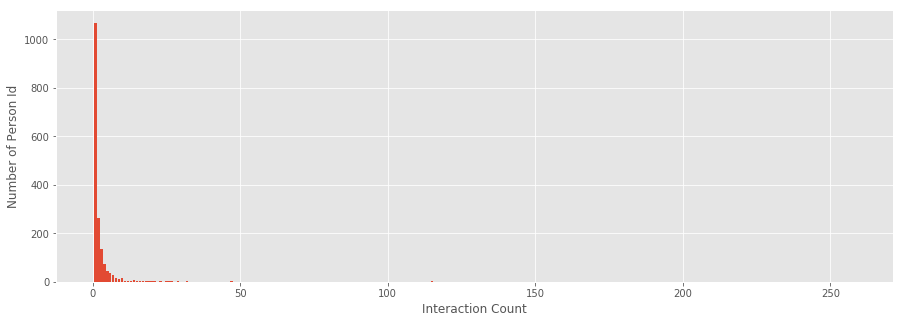

In [329]:
user_interaction_category = users_interactions_count_df.reset_index()
user_interaction_category.columns = ['personId', 'interaction_count']
user_interaction_category.head()

user_interaction_count_summary = user_interaction_category.groupby(['interaction_count'])['personId'].count().reset_index()

%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
plt.bar(user_interaction_count_summary['interaction_count'], user_interaction_count_summary['personId'])
plt.xlabel("Interaction Count")
plt.ylabel("Number of Person Id")
plt.show()

In [330]:
def interaction_category_func(df):
    if(df['interaction_count'] == 1):
        return("1")
    if(df['interaction_count'] == 2):
        return("2")
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return("3 to 5")
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return("6 to 10")
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return("11 to 50")
    if(df['interaction_count'] > 50):
        return("More than 50")
    else:
        return(np.nan)

def interaction_ordering_func(df):
    if(df['interaction_count'] == 1):
        return(1)
    if(df['interaction_count'] == 2):
        return(2)
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return(3)
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return(4)
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return(5)
    if(df['interaction_count'] > 50):
        return(6)
    else:
        return(np.nan)
    
user_interaction_category['interaction_category'] = user_interaction_category.apply(interaction_category_func, axis = 1)
user_interaction_category['order'] = user_interaction_category.apply(interaction_ordering_func, axis = 1)
user_interaction_category.groupby(['order', 'interaction_category'])['personId'].count().reset_index()

,order,interaction_category,personId
0,1,1,1066
1,2,2,263
2,3,3 to 5,252
3,4,6 to 10,106
4,5,11 to 50,78
5,6,More than 50,34


# Evaluation

In [331]:
interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_multi_df,
                                   stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
                                   #stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))

# interactions on Multi Train set: 6172
# interactions on Multi Test set (These are old customers with History): 1544
# interactions on Single Train set: 852
# interactions on Single Test set (These are new customers with no History): 214


In [332]:
for_N_test_case = interactions_multi_test_df.copy()
for_N_test_case['rank'] = for_N_test_case.groupby(['personId'])['contentId'].apply(lambda x: x.rank())
for_N_test_case = for_N_test_case.sort_values(['personId', 'rank'], ascending = [True, True])

N_test_cases = for_N_test_case[for_N_test_case['rank']<=10].copy()
add_rest_to_train = for_N_test_case[for_N_test_case['rank']>10].copy()

N_test_cases = N_test_cases.drop(['rank'], axis=1)
add_rest_to_train = add_rest_to_train.drop(['rank'], axis=1)

print("N_test_cases: ", N_test_cases.shape)
print("add_rest_to_train: ", add_rest_to_train.shape)

N_test_cases:  (1124, 3)
add_rest_to_train:  (420, 3)


In [333]:
interactions_multi_train_df = interactions_multi_train_df.append(add_rest_to_train)
interactions_multi_test_df = N_test_cases

In [334]:
print("interactions_multi_train_df: ", interactions_multi_train_df.shape)
print("interactions_multi_test_df: ", interactions_multi_test_df.shape)

interactions_multi_train_df:  (6592, 3)
interactions_multi_test_df:  (1124, 3)


In [335]:
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [336]:
#Indexing by personId to speed up the searches during evaluation
#interactions_full_indexed_df = interactions_multi_df.set_index('personId')
#interactions_train_indexed_df = interactions_train_df.set_index('personId')
#interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [337]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')

In [338]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

In [339]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [340]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [341]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [342]:
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [343]:
#Customisation
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=1000000000)
    top_100_reco = person_recs_df[0:100]
    
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10
        

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    hits_at_all_count = sum(pd.Series(list(person_interacted_items_testset)).isin(top_100_reco['contentId']))
    
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
    recall_at_all = hits_at_all_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@all_count':hits_at_all_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@all': recall_at_all,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [344]:
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength'])
    
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if(pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)  
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
    print('%d users processed' % idx)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
    
    
    return global_metrics, detailed_results_df, reco_list

In [345]:
#Customisation
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength'])
    
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if(pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)  
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
    print('%d users processed' % idx)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_all = detailed_results_df['hits@all_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                        'recall@all': global_recall_at_all}
    
    
    return global_metrics, detailed_results_df, reco_list

# Popularity Model

In [346]:
#Computes the most popular items
#item_popularity_df = interactions_multi_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#item_popularity_df.head(10)

In [347]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()
#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,140.070747
1,5ebb8db54b04f6003dd86570,139.049821
2,5e782cd3ea7e440022515910,116.947231
3,5ea2c5e5d4abf40029d88e2f,110.560251
4,5eb64ff240ca75004c486c14,81.012611
5,5eb39dc7854ebb0022622aa0,72.591841
6,5eb78f0117e19d00491830ab,65.517243
7,5eb23edc7056fb002fab0c65,65.116189
8,5ea153885738810038814fcf,61.543283
9,5e95945b41a162004c575518,56.617627


In [348]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [349]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...
683 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.21225710014947682, 'recall@10': 0.34902840059790735, 'recall@all': 0.18684603886397608}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,4,2,1,10,Popularity,0.4,0.2,0.1
72,5df728e2d092c70016203a92,2,0,0,10,Popularity,0.2,0.0,0.0
39,5df46f927e4ea600161b9266,3,2,0,10,Popularity,0.3,0.2,0.0
303,5e95d64bbdca200024b49f17,1,0,0,10,Popularity,0.1,0.0,0.0
42,5df471bd7e4ea600161b92be,5,1,0,10,Popularity,0.5,0.1,0.0


In [350]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.00821917808219178


In [351]:
def summary_results_func(detailed_results_df, mod_global_metrics):
    detailed_results_df = pd.merge(detailed_results_df, user_interaction_category, how = 'left', left_on = '_person_id', right_on = 'personId')
    detailed_results_df = detailed_results_df.drop(['personId'], axis = 1)
    mod_summary = detailed_results_df.groupby(['order', 'interaction_category']).agg({'_person_id':'count', 'recall@10':'mean', 'recall@5':'mean', 'recall@all':'mean', 'interacted_count':'mean'}).reset_index()
    mod_summary = mod_summary.rename(columns = {'interacted_count':'interacted_in_test_avg'})
    
    overall_summary = pd.DataFrame(index = [0], columns=mod_summary.columns)
    overall_summary['order'] = mod_summary['order'].max()+1
    overall_summary['interaction_category'] = 'Total'
    overall_summary['_person_id'] = mod_summary['_person_id'].sum()
    overall_summary['recall@10'] = mod_global_metrics['recall@10']
    overall_summary['recall@5'] = mod_global_metrics['recall@5']
    overall_summary['recall@all'] = mod_global_metrics['recall@all']
    overall_summary['interacted_in_test_avg'] = sum(mod_summary['interacted_in_test_avg']*mod_summary['_person_id'])/sum(mod_summary['_person_id'])
    final_mod_summary = mod_summary.append(overall_summary)
    return(final_mod_summary)


In [352]:
pop_summary = summary_results_func(pop_detailed_results_df, pop_global_metrics)
pop_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,214,0.457944,0.341121,0.331776,1.000000
1,3,3 to 5,252,0.349206,0.210317,0.186508,1.000000
2,4,6 to 10,106,0.377358,0.250000,0.240566,1.622642
3,5,11 to 50,78,0.313395,0.179635,0.147731,4.615385
4,6,More than 50,34,0.308824,0.141176,0.111765,10.000000
0,7,Total,684,0.349028,0.212257,0.186846,1.956140


# Content-Based Filtering model

In [353]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2555x1717 sparse matrix of type '<class 'numpy.float64'>'
	with 51766 stored elements in Compressed Sparse Row format>

In [354]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [265]:
user_profiles = build_users_profiles()
len(user_profiles)

1574

In [266]:
myprofile = user_profiles['5df4c077a68eb700165a66c3']
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['5df4c077a68eb700165a66c3'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1717)


,token,relevance
0,hi,0.180848
1,kool,0.164090
2,community,0.142146
3,help,0.140532
4,work,0.130972
5,everyone,0.129214
6,looking,0.117492
7,would,0.111603
8,kool kanya,0.109454
9,hey,0.108203


In [267]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [268]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [270]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
683 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.17713004484304934, 'recall@10': 0.26606875934230195, 'recall@all': 0.16292974588938713}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Content-Based,0.0,0.0,0.0
72,5df728e2d092c70016203a92,2,2,1,10,Content-Based,0.2,0.2,0.1
39,5df46f927e4ea600161b9266,2,2,2,10,Content-Based,0.2,0.2,0.2
303,5e95d64bbdca200024b49f17,2,0,0,10,Content-Based,0.2,0.0,0.0
42,5df471bd7e4ea600161b92be,2,2,0,10,Content-Based,0.2,0.2,0.0
293,5e94802ee4ffc40045a924dd,3,1,0,10,Content-Based,0.3,0.1,0.0
44,5df475827e4ea600161b9344,2,0,0,10,Content-Based,0.2,0.0,0.0
279,5e8dd87568e75f004d098de7,1,0,1,10,Content-Based,0.1,0.0,0.1
47,5df478bd7e4ea600161b93f5,2,2,2,10,Content-Based,0.2,0.2,0.2
65,5df4a890a68eb700165a65b9,2,2,2,10,Content-Based,0.2,0.2,0.2


In [271]:
temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.22953736654804271 for  470  Users
0.45794392523364486 for  214  Users


In [273]:
cb_summary = summary_results_func(cb_detailed_results_df, cb_global_metrics)
cb_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,214,0.457944,0.341121,0.331776,1.000000
1,3,3 to 5,252,0.242063,0.178571,0.158730,1.000000
2,4,6 to 10,106,0.146226,0.103774,0.099057,1.622642
3,5,11 to 50,78,0.240685,0.155072,0.125906,4.615385
4,6,More than 50,34,0.241176,0.138235,0.126471,10.000000
0,7,Total,684,0.266069,0.177130,0.162930,1.956140


In [274]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.5894324853228963


# Collaborative Filtering model

### Matrix Factorization

In [276]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,5df454f37e4ea600161b8e2e,5df4556a7e4ea600161b8e32,5df456257e4ea600161b8e41,5df457077e4ea600161b8e53,5df457ad7e4ea600161b8e6b,5df458dd7e4ea600161b8e8f,5df45ae07e4ea600161b8ed9,5df45c817e4ea600161b8f00,5df45d8f7e4ea600161b8f25,5df45ec37e4ea600161b8f68,...,5ec25d46c93e790022898e4e,5ec25dd5c93e790022898e52,5ec25ea74482a4002808c5e6,5ec261e34482a4002808c600,5ec262954482a4002808c603,5ec26961c93e790022898e70,5ec26da64482a4002808c627,5ec279f44482a4002808c68d,5ec27b84c93e790022898ea8,5ec27be54482a4002808c68f
personId,,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df431157e4ea600161b8e13,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454297e4ea600161b8e25,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454d27e4ea600161b8e2a,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4561e7e4ea600161b8e3e,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456267e4ea600161b8e43,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456497e4ea600161b8e49,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df457557e4ea600161b8e5c,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4577c7e4ea600161b8e60,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
users_items_pivot_matrix_df.shape

(1585, 1976)

In [278]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.32192809, 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [279]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['5df38de0b2694d0016bdb71f',
 '5df431157e4ea600161b8e13',
 '5df454297e4ea600161b8e25',
 '5df454d27e4ea600161b8e2a',
 '5df4561e7e4ea600161b8e3e',
 '5df456267e4ea600161b8e43',
 '5df456497e4ea600161b8e49',
 '5df457557e4ea600161b8e5c',
 '5df4577c7e4ea600161b8e60',
 '5df4579f7e4ea600161b8e68']

In [280]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1585x1976 sparse matrix of type '<class 'numpy.float64'>'
	with 7444 stored elements in Compressed Sparse Row format>

In [281]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print("U", U.shape)
print("Vt", Vt.shape)
sigma = np.diag(sigma)
print("sigma", sigma.shape)

U (1585, 20)
Vt (20, 1976)
sigma (20, 20)


In [282]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
print(all_user_predicted_ratings.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

(1585, 1976)


In [283]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,5df38de0b2694d0016bdb71f,5df431157e4ea600161b8e13,5df454297e4ea600161b8e25,5df454d27e4ea600161b8e2a,5df4561e7e4ea600161b8e3e,5df456267e4ea600161b8e43,5df456497e4ea600161b8e49,5df457557e4ea600161b8e5c,5df4577c7e4ea600161b8e60,5df4579f7e4ea600161b8e68,...,5ec163129ba71500223e7a3b,5ec1767f9ba71500223e7a65,5ec178519ba71500223e7a6b,5ec184c79ba71500223e7a84,5ec1e5a89ba71500223e7ae3,5ec25a6fc93e790022898e38,5ec260ca4482a4002808c5f2,5ec27351c93e790022898e96,5ec273a1c93e790022898e99,5ec27bc9c93e790022898ead
contentId,,,,,,,,,,,,,,,,,,,,,
5df454f37e4ea600161b8e2e,0.229395,0.234595,0.233810,0.233940,0.235158,0.234193,0.233950,0.234362,0.233814,0.239840,...,0.233901,0.233951,0.233894,0.233731,0.233897,0.233939,0.233932,0.233939,0.233862,0.233897
5df4556a7e4ea600161b8e32,0.229395,0.234595,0.233810,0.233940,0.235158,0.234193,0.233950,0.234362,0.233814,0.239840,...,0.233901,0.233951,0.233894,0.233731,0.233897,0.233939,0.233932,0.233939,0.233862,0.233897
5df456257e4ea600161b8e41,0.238889,0.234058,0.233988,0.233937,0.234140,0.233994,0.233938,0.234028,0.233898,0.234662,...,0.233945,0.233911,0.233950,0.233854,0.233933,0.233939,0.233934,0.233939,0.233953,0.233933
5df457077e4ea600161b8e53,0.232908,0.233909,0.233855,0.233939,0.234303,0.233944,0.233942,0.233940,0.234003,0.234368,...,0.233938,0.233923,0.233920,0.233987,0.233932,0.233939,0.233938,0.233939,0.233915,0.233932
5df457ad7e4ea600161b8e6b,0.237474,0.233956,0.233920,0.233937,0.233399,0.233991,0.233945,0.233955,0.233745,0.234021,...,0.233904,0.233994,0.233899,0.233762,0.233944,0.233939,0.233948,0.233939,0.233881,0.233944
5df458dd7e4ea600161b8e8f,0.234346,0.234715,0.233859,0.233938,0.235359,0.234248,0.233949,0.234452,0.233774,0.240563,...,0.233907,0.233924,0.233905,0.233647,0.233891,0.233939,0.233927,0.233939,0.233877,0.233891
5df45ae07e4ea600161b8ed9,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,...,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939
5df45c817e4ea600161b8f00,0.246918,0.233313,0.234060,0.233932,0.238832,0.234432,0.233888,0.234158,0.235677,0.231747,...,0.234025,0.234096,0.233984,0.234620,0.233871,0.233939,0.233921,0.233939,0.234109,0.233870
5df45d8f7e4ea600161b8f25,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,...,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939,0.233939


In [284]:
len(cf_preds_df.columns)

1585

In [285]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [286]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
683 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.24887892376681614, 'recall@10': 0.3617339312406577, 'recall@all': 0.21898355754857998}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,1,0,1,10,Collaborative Filtering,0.1,0.0,0.1
72,5df728e2d092c70016203a92,7,6,3,10,Collaborative Filtering,0.7,0.6,0.3
39,5df46f927e4ea600161b9266,8,8,5,10,Collaborative Filtering,0.8,0.8,0.5
303,5e95d64bbdca200024b49f17,1,1,1,10,Collaborative Filtering,0.1,0.1,0.1
42,5df471bd7e4ea600161b92be,4,4,3,10,Collaborative Filtering,0.4,0.4,0.3
293,5e94802ee4ffc40045a924dd,5,3,1,10,Collaborative Filtering,0.5,0.3,0.1
44,5df475827e4ea600161b9344,3,1,1,10,Collaborative Filtering,0.3,0.1,0.1
279,5e8dd87568e75f004d098de7,1,0,1,10,Collaborative Filtering,0.1,0.0,0.1
47,5df478bd7e4ea600161b93f5,1,1,1,10,Collaborative Filtering,0.1,0.1,0.1
65,5df4a890a68eb700165a65b9,2,0,0,10,Collaborative Filtering,0.2,0.0,0.0


In [287]:
temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.34341637010676157 for  470  Users
0.45794392523364486 for  214  Users


In [289]:
cf_summary = summary_results_func(cf_detailed_results_df, cf_global_metrics)
cf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,214,0.457944,0.341121,0.331776,1.000000
1,3,3 to 5,252,0.380952,0.230159,0.210317,1.000000
2,4,6 to 10,106,0.382075,0.240566,0.207547,1.622642
3,5,11 to 50,78,0.315125,0.224013,0.176984,4.615385
4,6,More than 50,34,0.302941,0.220588,0.191176,10.000000
0,7,Total,684,0.361734,0.248879,0.218984,1.956140


In [290]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.2410958904109589


In [291]:
cf_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrength
0,5e17112e2d853e0016d15f80,0.691575
1,5e8a3473b0c1e80028aa0b9f,0.615173
2,5e1bf12282331f00165573ce,0.612681
3,5e41010a1022e000161eb0ac,0.609079
4,5e44cb2b18f56700165403c7,0.583241
5,5e92da13c75e94003667a1a6,0.571195
6,5e1e987603561a0016a86ece,0.570969
7,5e53b6feba993000169591be,0.569825
8,5e3b8b649f0b4a0016dc081e,0.564433
9,5e782cd3ea7e440022515910,0.556943


### Hybrid Recommendation 

In [292]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)


In [293]:
hybrid_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrengthCB,recStrengthCF,recStrengthHybrid
13,5e17112e2d853e0016d15f80,0.294474,0.691575,69.451978
676,5e8a3473b0c1e80028aa0b9f,0.164833,0.615173,61.682085
14,5e1bf12282331f00165573ce,0.293372,0.612681,61.561426
178,5e41010a1022e000161eb0ac,0.221849,0.609079,61.129723
945,5e44cb2b18f56700165403c7,0.146370,0.583241,58.470492
33,5e1e987603561a0016a86ece,0.269548,0.570969,57.366400
935,5e92da13c75e94003667a1a6,0.147088,0.571195,57.266610
1000,5e53b6feba993000169591be,0.000000,0.569825,56.982469
119,5e3b8b649f0b4a0016dc081e,0.236634,0.564433,56.679981
4,5e782cd3ea7e440022515910,0.320439,0.556943,56.014757


In [294]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
683 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.26382660687593423, 'recall@10': 0.3632286995515695, 'recall@all': 0.2428998505231689}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,1,0,1,10,Hybrid,0.1,0.0,0.1
72,5df728e2d092c70016203a92,6,6,4,10,Hybrid,0.6,0.6,0.4
39,5df46f927e4ea600161b9266,8,8,6,10,Hybrid,0.8,0.8,0.6
303,5e95d64bbdca200024b49f17,2,1,1,10,Hybrid,0.2,0.1,0.1
42,5df471bd7e4ea600161b92be,4,4,3,10,Hybrid,0.4,0.4,0.3
293,5e94802ee4ffc40045a924dd,5,3,2,10,Hybrid,0.5,0.3,0.2
44,5df475827e4ea600161b9344,2,1,1,10,Hybrid,0.2,0.1,0.1
279,5e8dd87568e75f004d098de7,1,0,1,10,Hybrid,0.1,0.0,0.1
47,5df478bd7e4ea600161b93f5,1,1,1,10,Hybrid,0.1,0.1,0.1
65,5df4a890a68eb700165a65b9,2,0,0,10,Hybrid,0.2,0.0,0.0


In [295]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.34519572953736655 for  470  Users
0.45794392523364486 for  214  Users


In [298]:
hybrid_summary = summary_results_func(hybrid_detailed_results_df, hybrid_global_metrics)
hybrid_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,214,0.457944,0.341121,0.331776,1.000000
1,3,3 to 5,252,0.380952,0.285714,0.257937,1.000000
2,4,6 to 10,106,0.358491,0.268868,0.240566,1.622642
3,5,11 to 50,78,0.345788,0.230993,0.207789,4.615385
4,6,More than 50,34,0.302941,0.214706,0.200000,10.000000
0,7,Total,684,0.363229,0.263827,0.242900,1.956140


In [299]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.3311154598825832


# Comparing Methods

In [300]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5,recall@all
modelName,,,
Content-Based,0.266069,0.177130,0.162930
Popularity,0.349028,0.212257,0.186846
Collaborative Filtering,0.361734,0.248879,0.218984
Hybrid,0.363229,0.263827,0.242900


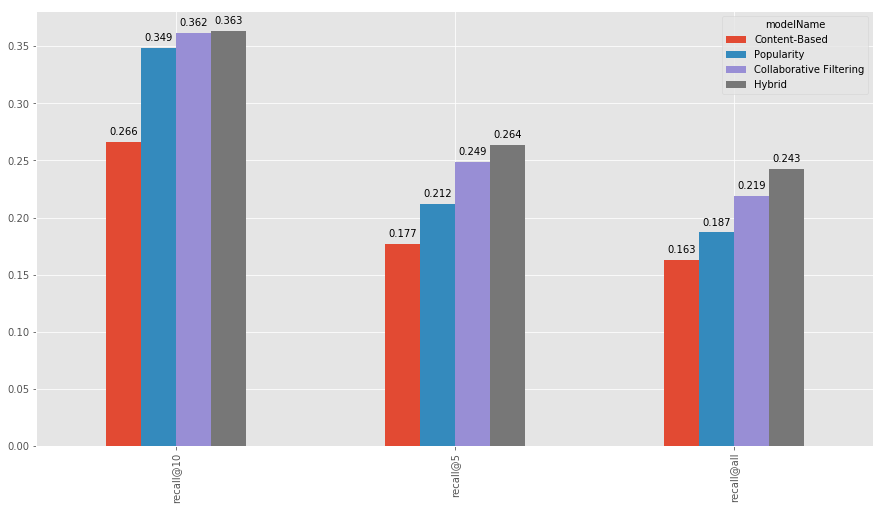

In [301]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [302]:
pop_summary['model'] = 'popularity'
cb_summary['model'] = 'content based'
cf_summary['model'] = 'collaborative filtering'
hybrid_summary['model'] = 'hybrid'

total_summary = pop_summary.append([cb_summary, cf_summary, hybrid_summary])
total_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg,model
0,1,1,214,0.457944,0.341121,0.331776,1.000000,popularity
1,3,3 to 5,252,0.349206,0.210317,0.186508,1.000000,popularity
2,4,6 to 10,106,0.377358,0.250000,0.240566,1.622642,popularity
3,5,11 to 50,78,0.313395,0.179635,0.147731,4.615385,popularity
4,6,More than 50,34,0.308824,0.141176,0.111765,10.000000,popularity
0,7,Total,684,0.349028,0.212257,0.186846,1.956140,popularity
0,1,1,214,0.457944,0.341121,0.331776,1.000000,content based
1,3,3 to 5,252,0.242063,0.178571,0.158730,1.000000,content based
2,4,6 to 10,106,0.146226,0.103774,0.099057,1.622642,content based
3,5,11 to 50,78,0.240685,0.155072,0.125906,4.615385,content based


In [303]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@10')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity
interaction_category,,,,
1,0.457944,0.457944,0.457944,0.457944
3 to 5,0.380952,0.242063,0.380952,0.349206
6 to 10,0.382075,0.146226,0.358491,0.377358
11 to 50,0.315125,0.240685,0.345788,0.313395
More than 50,0.302941,0.241176,0.302941,0.308824
Total,0.361734,0.266069,0.363229,0.349028


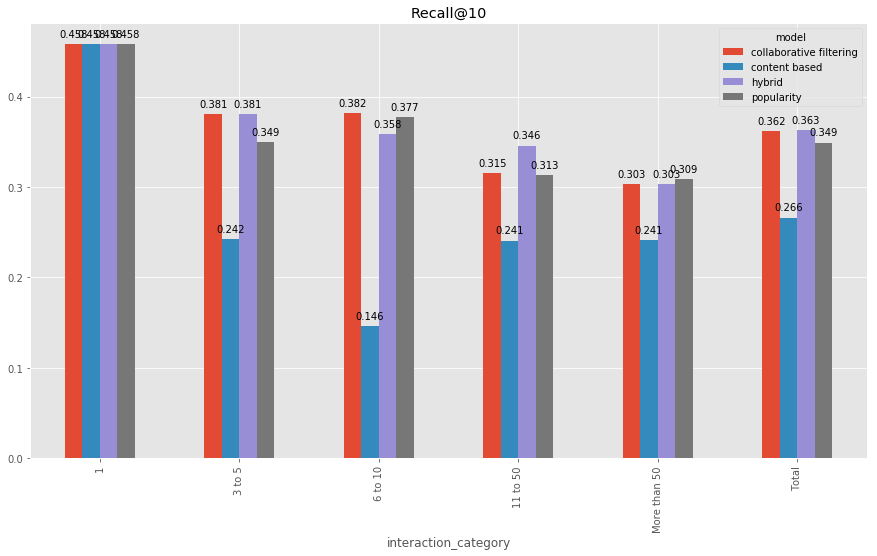

In [304]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@10')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [305]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@all')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity
interaction_category,,,,
1,0.331776,0.331776,0.331776,0.331776
3 to 5,0.210317,0.158730,0.257937,0.186508
6 to 10,0.207547,0.099057,0.240566,0.240566
11 to 50,0.176984,0.125906,0.207789,0.147731
More than 50,0.191176,0.126471,0.200000,0.111765
Total,0.218984,0.162930,0.242900,0.186846


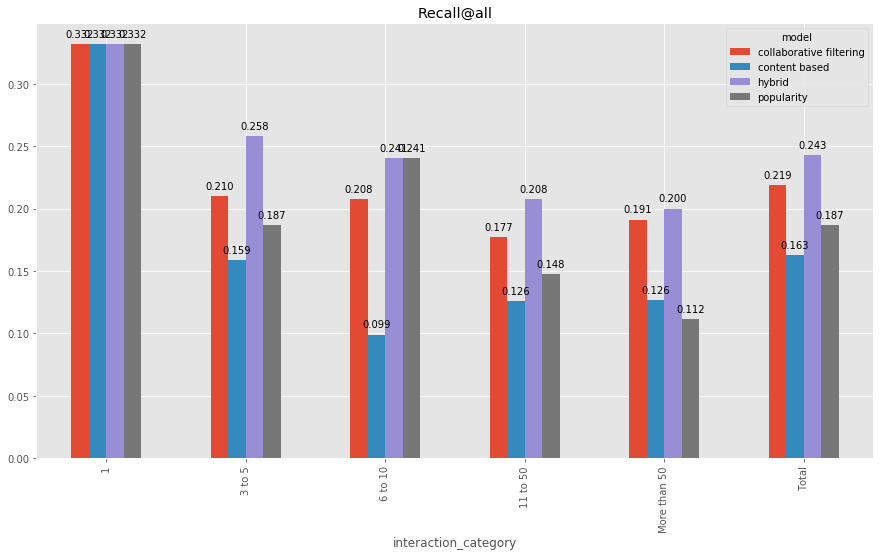

In [306]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@all')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [307]:
popularity_model.recommend_items(user_id = 'dummy', items_to_ignore=[], topn=10, verbose=False)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,140.070747
1,5ebb8db54b04f6003dd86570,139.049821
2,5e782cd3ea7e440022515910,116.947231
3,5ea2c5e5d4abf40029d88e2f,110.560251
4,5eb64ff240ca75004c486c14,81.012611
5,5eb39dc7854ebb0022622aa0,72.591841
6,5eb78f0117e19d00491830ab,65.517243
7,5eb23edc7056fb002fab0c65,65.116189
8,5ea153885738810038814fcf,61.543283
9,5e95945b41a162004c575518,56.617627


In [308]:
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,140.070747
1,5ebb8db54b04f6003dd86570,139.049821
2,5e782cd3ea7e440022515910,116.947231
3,5ea2c5e5d4abf40029d88e2f,110.560251
4,5eb64ff240ca75004c486c14,81.012611
5,5eb39dc7854ebb0022622aa0,72.591841
6,5eb78f0117e19d00491830ab,65.517243
7,5eb23edc7056fb002fab0c65,65.116189
8,5ea153885738810038814fcf,61.543283
9,5e95945b41a162004c575518,56.617627
